In [1]:
import pandas as pd
df = pd.read_excel("kijangemas_quelle.xlsx")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [3]:
timestamp, selling = [], []  
timestamp = pd.DatetimeIndex(df['Date']).date
selling = df["1 oz Sell"]
len(timestamp), len(selling) # (689, 689)

(689, 689)

In [4]:
df2 = pd.DataFrame({'timestamp': timestamp, 'selling': selling})
df2.head()

,timestamp,selling
0,2018-01-03,5632.0
1,2018-01-04,5579.0
2,2018-01-05,5608.0
3,2018-01-08,5585.0
4,2018-01-09,5592.0


In [5]:
# Our model should forecast 61 future days ahead
future_count = 62
len(selling) - future_count # 627
train_selling = selling[: len(selling) - future_count] 
test_selling = selling[len(selling) - future_count :]

In [6]:
# Linear regression
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression().fit(
    np.arange(len(train_selling)).reshape((-1, 1)), train_selling
)
linear_future = linear_regression.predict(
    np.arange(len(train_selling) + future_count).reshape((-1, 1))
)

Wall time: 130 ms


In [7]:
# Statsmodels allows users to explore data, estimate statistical models, and perform statistical tests
import statsmodels.api as sm 

# The sklearn.preprocessing package provides several common utility functions and transformer classes 
# to change raw feature vectors into a representation that is more suitable for the downstream estimators
# MinMaxScaler rescales the data set such that all feature values are in the given range
from sklearn.preprocessing import MinMaxScaler

# Importing the product tool which computes the cartesian product of input iterables
from itertools import product

In [8]:
# SARIMA = Seasonal ARIMA = Extension of ARIMA that explicitly supports univariate time series data with a seasonal component
Qs = range(0, 2)     # Seasonal moving average order
qs = range(0, 2)     # Trend moving average order
Ps = range(0, 2)     # Seasonal autoregressive order
ps = range(0, 2)     # Trend autoregression order
D = 1                # Seasonal difference order
d = 1                # Trend difference order
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list) # 16

16

In [9]:
# Problem with ARIMA: We cannot feed a high value, so we need to scale; here: minmax scaling

# fit() computes the minimum and maximum to be used for later scaling
minmax = MinMaxScaler().fit(np.array([train_selling]).T)

# transform(X) scales features of X according to feature_range
minmax_values = minmax.transform(np.array([train_selling]).T)

In [10]:
# Searching for the best pairs of parameters where AIC is the lowest 
best_aic = float("inf")
for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(
            minmax_values[:, 0],
            order = (param[0], d, param[1]),
            seasonal_order = (param[2], D, param[3], future_count),
        ).fit(disp = -1)
    except Exception as e:
        print(e)
        continue
    aic = model.aic
    if aic < best_aic and aic:
        best_model = model
        best_aic = aic
best_aic # -2937.089528205006

# Dieser Code nimmt etwa 20 Minuten Zeit in Anspruch! 
# ConvergenceWarning wird mehrfach ausgegeben, wir ignorieren dies einfach.

C:\Users\Manh Tuan Nguyen\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Manh Tuan Nguyen\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Manh Tuan Nguyen\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Manh Tuan Nguyen\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Wall time: 15min 29s


-2937.089528205006

In [11]:
print(best_model.summary()) 

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  627
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 62)   Log Likelihood                1470.545
Date:                              Wed, 02 Dec 2020   AIC                          -2937.090
Time:                                      16:05:35   BIC                          -2928.419
Sample:                                           0   HQIC                         -2933.705
                                              - 627                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L62      -0.7663      0.037    -20.529      0.000      -0.839      -0.693
sigma2         0.00

In [12]:
# Computing prediction results
arima_future = best_model.get_prediction(
    start = 0, end = len(train_selling) + future_count - 1
)

# inverse_transform(X): Undo the scaling of X according to feature_range
arima_future = minmax.inverse_transform(
    np.expand_dims(arima_future.predicted_mean, axis = 1)
)[:, 0]

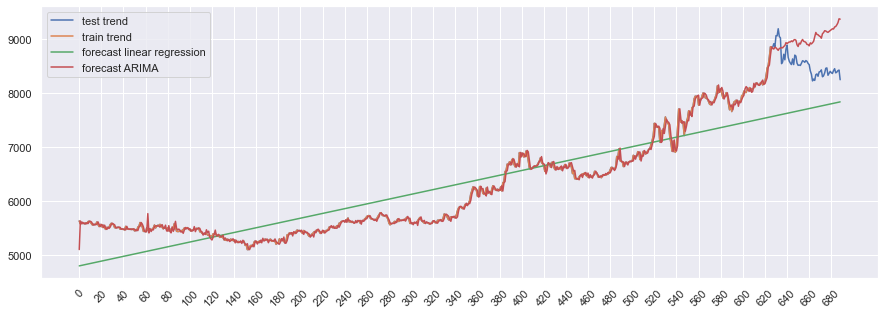

In [13]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selling, label = 'test trend')
ax.plot(train_selling, label = 'train trend')
ax.plot(linear_future, label = 'forecast linear regression')
ax.plot(arima_future, label = 'forecast ARIMA')
plt.xticks(
    np.arange(len(timestamp))[::20],
    np.arange(len(timestamp))[::20],
    rotation = '45',
)
plt.legend()
plt.show()

In [14]:
# Coefficient of Determination R squared (Bestimmtheitsmaß)
from sklearn.metrics import r2_score

# Pearson and Spearman Correlation
from scipy.stats import pearsonr, spearmanr

In [15]:
# Accuracy based on correlation coefficient, higher is better!
def calculate_accuracy(real, predict):
    r2 = r2_score(real, predict)
    if r2 < 0:
        r2 = 0

    def change_percentage(val): 
    # minmax, we know that correlation is between -1 and 1
        if val > 0:
            return val
        else:
            return val + 1

    pearson = pearsonr(real, predict)[0]
    spearman = spearmanr(real, predict)[0]
    pearson = change_percentage(pearson)
    spearman = change_percentage(spearman)
    return {
        'r2': r2 * 100,
        'pearson': pearson * 100,
        'spearman': spearman * 100,
    }

In [16]:
# Distance error for mse and rmse, lower is better!
def calculate_distance(real, predict):
    mse = ((real - predict) ** 2).mean()
    rmse = np.sqrt(mse)
    return {'mse': mse, 'rmse': rmse}

In [17]:
# Validating based on training timestamps
arima_cut = arima_future[: len(train_selling)]

In [18]:
# Checking distance error using Mean Square Error and Root Mean Square Error
calculate_distance(train_selling, arima_cut)

{'mse': 4496.26783942488, 'rmse': 67.05421567228179}

In [19]:
# Checking accuracy 
calculate_accuracy(train_selling, arima_cut)

{'r2': 99.43615750421054,
 'pearson': 99.71892132447782,
 'spearman': 99.02293526972935}

In [20]:
# Validating based on test timestamps
arima_cut = arima_future[len(train_selling) :]

In [21]:
# Checking distance error using Mean Square Error and Root Mean Square Error
calculate_distance(test_selling, arima_cut)

{'mse': 322071.2735898548, 'rmse': 567.5132364886786}

In [22]:
# Checking accuracy
calculate_accuracy(test_selling, arima_cut)

{'r2': 0, 'pearson': 33.11011965176513, 'spearman': 30.25598403465416}